In [1]:
!pip install catboost shap -qqq 

In [108]:
seed = 0

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 55)

## Data loading

In [109]:
def load_data():
    df = pd.read_csv("540_data.csv")
    convert_dict = {
                    "pH": float,
                    'Catalyst Loading (mg/cm2)': float,
                    "Presence of atoms (other than TMs)" : float,
                    "Average d electrons": float,
                    'Overpotential (mV)': float
                }

    df = df.astype(convert_dict)
    df = df.drop(["Compound"], axis=1)
    return df

## Pre *processing*

In [110]:
atomicMassMap = {
    'cobalt': 64,
    'nickel': 59,
    'iron': 56,
    "molybdenum": 96,
    'manganese': 55,
    "copper": 64,
    "zinc": 65,
    "chromium": 52,
    "vanadium": 51,
    "tungsten": 184,
    "titanium": 48,
    "iridium": 192
}

In [111]:
def mulitply_number_of_atoms_to_its_mass_number():
    for col in df.columns:
        if col.lower().split(' ')[0] in atomicMassMap:
            df[col] = df[col].values.astype(float) * atomicMassMap[col.lower().split(' ')[0]]

In [112]:
def find_and_handle_missing_values(model_name):
    print("Missing values columns:", list(df.columns[df.isnull().any()]))

    if model_name != "catboost":
        df['Catalyst Loading (mg/cm2)'].fillna(df['Catalyst Loading (mg/cm2)'].mean() , inplace = True)
        df["Average d electrons"].fillna(df['Average d electrons'].mean() , inplace = True)

## Data analysis

In [113]:
def get_number_of_features():

    training_features = df.columns[0:-1]
    continuous_features = []
    categorical_features = []

    for col in training_features:
        if df[col].dtypes == float:
            continuous_features.append(col)
        else:
            categorical_features.append(col)

    total_number_of_features = len(training_features)
    print("Total number of training features: ", total_number_of_features) 

    print("Number of continuous variables:", len(continuous_features))
    print("Continuous features:", continuous_features)

    print("Number of categorical variables: ", len(categorical_features))
    print("Categorical features:", categorical_features)

    return training_features, continuous_features, categorical_features

In [114]:
def categorical_features_count_plot(categorical_features):
    unique, counts = np.unique(df['overpotential_grades'].values, return_counts=True)
    sns.countplot(x="overpotential_grades", data=df)

In [115]:
def plot_correlation(data):
    plt.subplots(figsize=(16,16))
    dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
    plt.show()

## Train test split

In [116]:
from sklearn.model_selection import train_test_split

In [117]:
def split_data_into_train_test():
    x = df.values[:, 0:-1]
    y = df.values[:, -1]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state = seed, stratify=y
    )
    return x_train, x_test, y_train, y_test

In [118]:
def train_and_test_split():
    x_train, x_test, y_train, y_test = split_data_into_train_test()

    print(x_train[0])
    print(y_train[0])
    print(type(x_train), type(y_train))
    print("number of train data: ", len(y_train))
    print("number of test data: ", len(y_test))

    return x_train, y_train, x_test, y_test

## Error **analysis**

In [119]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def get_metrics(model, x_test, y_test):

    y_pred = model.predict(x_test)
    y_prob_pred = model.predict_proba(x_test)
    cf_matrix = confusion_matrix(y_test, y_pred, labels = grades)
    accuracy = accuracy_score(y_test, y_pred )
    class_report = classification_report(y_test, y_pred)
    
    return accuracy, cf_matrix, class_report

In [120]:
def get_feature_importance_from_trained_model(model):

    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    return feature_importance, sorted_idx

In [121]:
def plot_feature_importance(feature_importance, sorted_idx):
    fig = plt.figure(figsize=(20, 10))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), training_features[sorted_idx])
    plt.title('Feature Importance')

## Encoding cat_features

In [122]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(df):
    types_of_compounds = list(df['Compound Class'].value_counts().keys())
    types_of_substrates = list(df['Substrates'].value_counts().keys())
    
    labelencoder = LabelEncoder()
    df['Compound Class']= labelencoder.fit_transform(df['Compound Class'])
    df['Substrates']= labelencoder.fit_transform(df['Substrates'])

    compound_encoding_labels = {}
    a1 = list(df['Compound Class'].value_counts().keys())
    for i in range(len(a1)):
        compound_encoding_labels[types_of_compounds[i]] = a1[i]

    substrate_encoding_labels = {}
    a2 = list(df['Substrates'].value_counts().keys())
    for i in range(len(a2)):
        substrate_encoding_labels[types_of_substrates[i]] = a2[i]

    return compound_encoding_labels, substrate_encoding_labels

In [123]:
def get_overpotential_grades(overpotential):

    overpotential_grades = []
    grades = ["A", "F"]

    for potential in overpotential:
        if potential < 351:
            overpotential_grades.append('A')

        else:
            overpotential_grades.append('F')

    return overpotential_grades, grades

## Random forest

Shape of data: (540, 28)
(array(['A', 'F'], dtype=object), array([358, 182], dtype=int64))
{'Co': 0, 'Ni': 2, 'Fe': 1, 'Other TMs': 3} {'GC': 0, 'NF': 1, 'carbon_based': 3, 'TM_based': 2}
Total number of training features:  27
Number of continuous variables: 16
Continuous features: ['Presence of atoms (other than TMs)', 'Cobalt atoms', 'Nickel atoms', 'Iron atoms', 'Molybdenum atoms', 'Manganese atoms', 'Copper atoms', 'Zinc atoms', 'Chromium Atoms', 'Vanadium Atoms', 'Tungsten atoms', 'Titanium atoms', 'Average d electrons', 'pH', 'Concentration Electrolyte', 'Catalyst Loading (mg/cm2)']
Number of categorical variables:  11
Categorical features: ['Compound Class', 'Composite (Y or N)', 'Oxided or nitrided', 'Presence of Carbon', 'Carbon Structures', 'N-doped Carbon Structure (0 or 1)', 'Doping (other than TMs)', 'Morphology Category', 'Grown on', 'Porous - 1, Non-Porous - 0', 'Substrates']
Missing values columns: ['Average d electrons', 'Catalyst Loading (mg/cm2)']


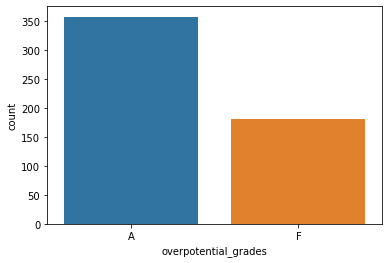

In [124]:
df = load_data()

print("Shape of data:", df.shape)

mulitply_number_of_atoms_to_its_mass_number()
overpotential_grades, grades = get_overpotential_grades(df["Overpotential (mV)"])
df['overpotential_grades'] = overpotential_grades
df = df.drop(["Overpotential (mV)"], axis=1)
print(np.unique(df['overpotential_grades'].values, return_counts=True))

compound_encoding_labels, substrate_encoding_labels = encode_categorical_features(df)
print(compound_encoding_labels, substrate_encoding_labels)

training_features, continuous_features, categorical_features = get_number_of_features()

model_name = "random_forest"
find_and_handle_missing_values(model_name)
df.to_csv("df_after_filling_missing_values.csv")
categorical_features_count_plot(categorical_features)

In [125]:
x_train, y_train, x_test, y_test = train_and_test_split()

[1 1 0 0 0 0 0 7 1 1 1 0.0 0.0 0.0 112.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 3.911740569508767 14.0 1.0 0.05]
F
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
number of train data:  432
number of test data:  108


In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

rf = RandomForestClassifier(random_state=seed, n_estimators=300,class_weight="balanced", max_depth=20, min_samples_leaf=2, min_samples_split=2, max_features="auto")
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, n_estimators=300, random_state=0)

accuracy_score:  0.7870370370370371
classification_report: 
               precision    recall  f1-score   support

           A       0.84      0.85      0.84        72
           F       0.69      0.67      0.68        36

    accuracy                           0.79       108
   macro avg       0.76      0.76      0.76       108
weighted avg       0.79      0.79      0.79       108



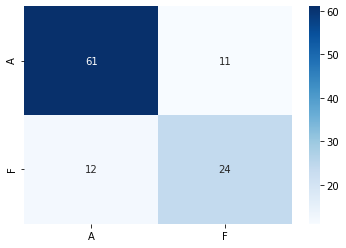

In [127]:
accuracy, cf_matrix, class_report = get_metrics(rf, x_test, y_test)
print("accuracy_score: ", accuracy)
print("classification_report: \n", class_report)
sns.heatmap(cf_matrix, annot = True, xticklabels = grades, yticklabels = grades, cmap = 'Blues')

[3.26971682e-02 3.76514845e-02 3.61727828e-02 1.43860683e-02
 2.92694917e-02 1.33417125e-02 1.72054181e-02 6.91479578e-02
 6.41204474e-02 5.14207848e-02 7.03329326e-02 2.17226899e-02
 6.91631558e-02 5.12916893e-02 5.70504963e-02 1.00828466e-02
 1.18711676e-02 1.67611863e-03 1.40224627e-02 9.65886389e-03
 5.57750971e-03 2.78117941e-05 6.89482350e-03 1.13624188e-01
 2.23830985e-02 2.58323046e-02 1.43374525e-01] [21 17 20 22 19 15 16  5 18  3  6 11 24 25  4  0  2  1 13  9 14  8  7 12
 10 23 26]


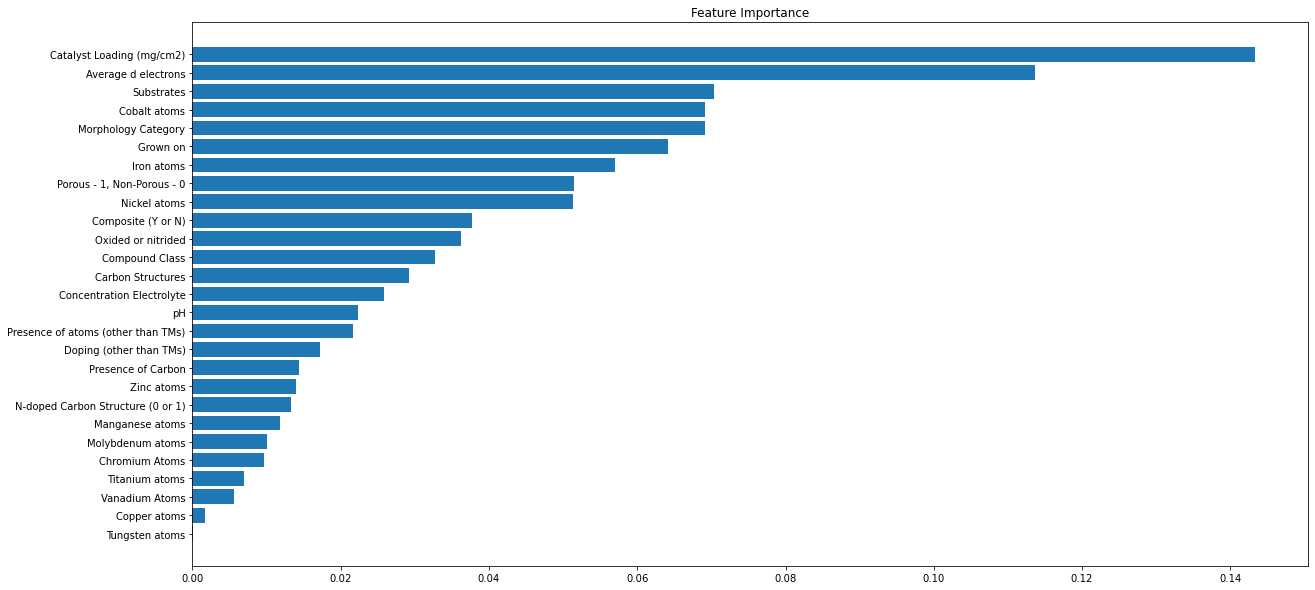

In [128]:
feature_importance, sorted_idx = get_feature_importance_from_trained_model(rf)
plot_feature_importance(feature_importance, sorted_idx)
print(feature_importance, sorted_idx)

In [129]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_test)

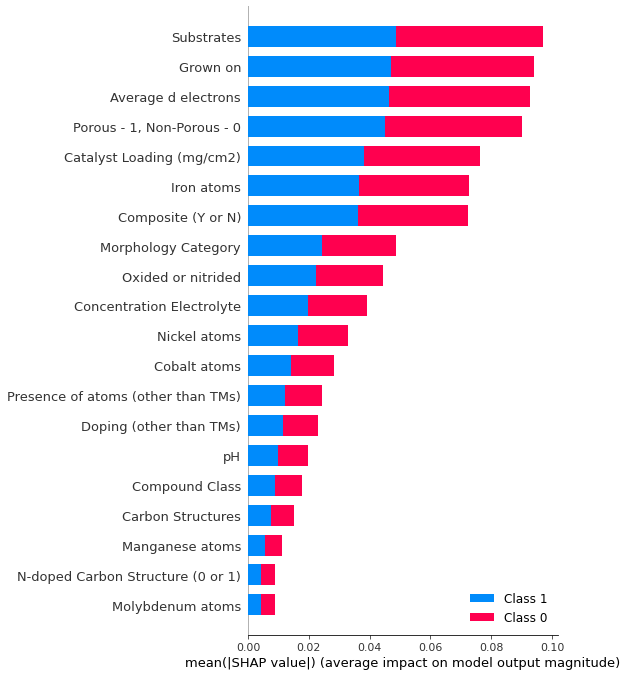

In [130]:
shap.summary_plot(shap_values, x_test, feature_names = training_features)

## Catboost

In [131]:
from catboost import CatBoostClassifier, Pool

In [144]:
def create_train_pool():
    cat_cols = [0,1,2,3,4,5,6,7,8,9,10]

    train_pool = Pool(
            x_train,
            y_train,
            cat_features=cat_cols
    )
    return train_pool

In [145]:
def define_model_parameters():

    model = CatBoostClassifier(
    iterations=1000,
    depth=5,
    random_seed= seed,
    )

    eval_set = [(x_train, y_train), (x_test, y_test)]
    return eval_set, model

In [146]:
train_pool = create_train_pool()
eval_set, cat_boost_model = define_model_parameters()

cat_boost_model.fit( 
    train_pool,
    eval_set = eval_set
    )

Learning rate set to 0.025756
0:	learn: 0.6873869	test: 0.6877614	test1: 0.6872623	best: 0.6872623 (0)	total: 31.8ms	remaining: 31.7s
1:	learn: 0.6832022	test: 0.6835743	test1: 0.6823613	best: 0.6823613 (1)	total: 58.7ms	remaining: 29.3s
2:	learn: 0.6767449	test: 0.6771568	test1: 0.6757960	best: 0.6757960 (2)	total: 90.9ms	remaining: 30.2s
3:	learn: 0.6713520	test: 0.6717657	test1: 0.6700932	best: 0.6700932 (3)	total: 113ms	remaining: 28s
4:	learn: 0.6639227	test: 0.6642731	test1: 0.6640334	best: 0.6640334 (4)	total: 148ms	remaining: 29.5s
5:	learn: 0.6570346	test: 0.6572920	test1: 0.6577216	best: 0.6577216 (5)	total: 187ms	remaining: 30.9s
6:	learn: 0.6516259	test: 0.6514822	test1: 0.6504620	best: 0.6504620 (6)	total: 233ms	remaining: 33s
7:	learn: 0.6442559	test: 0.6439187	test1: 0.6417808	best: 0.6417808 (7)	total: 271ms	remaining: 33.6s
8:	learn: 0.6403875	test: 0.6400638	test1: 0.6379113	best: 0.6379113 (8)	total: 299ms	remaining: 32.9s
9:	learn: 0.6355482	test: 0.6350630	test1: 0

83:	learn: 0.4723665	test: 0.4829791	test1: 0.5208247	best: 0.5203702 (80)	total: 3.13s	remaining: 34.1s
84:	learn: 0.4720891	test: 0.4826944	test1: 0.5207571	best: 0.5203702 (80)	total: 3.15s	remaining: 34s
85:	learn: 0.4720800	test: 0.4826885	test1: 0.5207533	best: 0.5203702 (80)	total: 3.16s	remaining: 33.6s
86:	learn: 0.4715130	test: 0.4821296	test1: 0.5204314	best: 0.5203702 (80)	total: 3.19s	remaining: 33.5s
87:	learn: 0.4703487	test: 0.4815208	test1: 0.5209396	best: 0.5203702 (80)	total: 3.24s	remaining: 33.6s
88:	learn: 0.4694007	test: 0.4808794	test1: 0.5207543	best: 0.5203702 (80)	total: 3.28s	remaining: 33.5s
89:	learn: 0.4686412	test: 0.4803446	test1: 0.5201858	best: 0.5201858 (89)	total: 3.31s	remaining: 33.5s
90:	learn: 0.4679035	test: 0.4795809	test1: 0.5193892	best: 0.5193892 (90)	total: 3.34s	remaining: 33.4s
91:	learn: 0.4668473	test: 0.4786198	test1: 0.5182551	best: 0.5182551 (91)	total: 3.37s	remaining: 33.2s
92:	learn: 0.4661988	test: 0.4780347	test1: 0.5184150	bes

163:	learn: 0.4075132	test: 0.4336203	test1: 0.5080059	best: 0.5053427 (156)	total: 5.96s	remaining: 30.4s
164:	learn: 0.4070797	test: 0.4332523	test1: 0.5079312	best: 0.5053427 (156)	total: 6s	remaining: 30.4s
165:	learn: 0.4060577	test: 0.4323147	test1: 0.5081040	best: 0.5053427 (156)	total: 6.04s	remaining: 30.3s
166:	learn: 0.4054498	test: 0.4316703	test1: 0.5071340	best: 0.5053427 (156)	total: 6.08s	remaining: 30.3s
167:	learn: 0.4049962	test: 0.4314249	test1: 0.5075561	best: 0.5053427 (156)	total: 6.12s	remaining: 30.3s
168:	learn: 0.4048578	test: 0.4312834	test1: 0.5077617	best: 0.5053427 (156)	total: 6.13s	remaining: 30.2s
169:	learn: 0.4043587	test: 0.4308669	test1: 0.5076729	best: 0.5053427 (156)	total: 6.17s	remaining: 30.1s
170:	learn: 0.4034791	test: 0.4304038	test1: 0.5077302	best: 0.5053427 (156)	total: 6.21s	remaining: 30.1s
171:	learn: 0.4030506	test: 0.4300495	test1: 0.5072743	best: 0.5053427 (156)	total: 6.25s	remaining: 30.1s
172:	learn: 0.4028249	test: 0.4299236	te

244:	learn: 0.3591388	test: 0.3991006	test1: 0.4934761	best: 0.4934063 (237)	total: 8.51s	remaining: 26.2s
245:	learn: 0.3582885	test: 0.3981802	test1: 0.4929117	best: 0.4929117 (245)	total: 8.55s	remaining: 26.2s
246:	learn: 0.3576748	test: 0.3974672	test1: 0.4927871	best: 0.4927871 (246)	total: 8.58s	remaining: 26.2s
247:	learn: 0.3570221	test: 0.3974924	test1: 0.4926462	best: 0.4926462 (247)	total: 8.61s	remaining: 26.1s
248:	learn: 0.3566926	test: 0.3972288	test1: 0.4923070	best: 0.4923070 (248)	total: 8.66s	remaining: 26.1s
249:	learn: 0.3562689	test: 0.3968862	test1: 0.4922074	best: 0.4922074 (249)	total: 8.69s	remaining: 26.1s
250:	learn: 0.3558103	test: 0.3964854	test1: 0.4921678	best: 0.4921678 (250)	total: 8.73s	remaining: 26.1s
251:	learn: 0.3554292	test: 0.3962041	test1: 0.4917966	best: 0.4917966 (251)	total: 8.77s	remaining: 26s
252:	learn: 0.3553753	test: 0.3961492	test1: 0.4918034	best: 0.4917966 (251)	total: 8.79s	remaining: 26s
253:	learn: 0.3550051	test: 0.3960510	tes

325:	learn: 0.3113355	test: 0.3645819	test1: 0.4848468	best: 0.4848468 (325)	total: 11.1s	remaining: 23s
326:	learn: 0.3108000	test: 0.3643171	test1: 0.4842610	best: 0.4842610 (326)	total: 11.1s	remaining: 22.9s
327:	learn: 0.3100446	test: 0.3635760	test1: 0.4846169	best: 0.4842610 (326)	total: 11.2s	remaining: 22.9s
328:	learn: 0.3098006	test: 0.3633698	test1: 0.4847886	best: 0.4842610 (326)	total: 11.2s	remaining: 22.8s
329:	learn: 0.3093905	test: 0.3630638	test1: 0.4850960	best: 0.4842610 (326)	total: 11.2s	remaining: 22.8s
330:	learn: 0.3089425	test: 0.3627373	test1: 0.4851462	best: 0.4842610 (326)	total: 11.2s	remaining: 22.7s
331:	learn: 0.3085285	test: 0.3625933	test1: 0.4848390	best: 0.4842610 (326)	total: 11.3s	remaining: 22.7s
332:	learn: 0.3078207	test: 0.3619000	test1: 0.4840963	best: 0.4840963 (332)	total: 11.3s	remaining: 22.6s
333:	learn: 0.3073723	test: 0.3617849	test1: 0.4839648	best: 0.4839648 (333)	total: 11.3s	remaining: 22.6s
334:	learn: 0.3066639	test: 0.3611777	t

403:	learn: 0.2746591	test: 0.3365601	test1: 0.4761326	best: 0.4761326 (403)	total: 13.6s	remaining: 20.1s
404:	learn: 0.2743871	test: 0.3362924	test1: 0.4759540	best: 0.4759540 (404)	total: 13.7s	remaining: 20.1s
405:	learn: 0.2741968	test: 0.3362362	test1: 0.4758868	best: 0.4758868 (405)	total: 13.7s	remaining: 20.1s
406:	learn: 0.2735852	test: 0.3355463	test1: 0.4759628	best: 0.4758868 (405)	total: 13.8s	remaining: 20s
407:	learn: 0.2723880	test: 0.3344904	test1: 0.4765093	best: 0.4758868 (405)	total: 13.8s	remaining: 20s
408:	learn: 0.2720284	test: 0.3342436	test1: 0.4764055	best: 0.4758868 (405)	total: 13.8s	remaining: 20s
409:	learn: 0.2716401	test: 0.3340507	test1: 0.4759425	best: 0.4758868 (405)	total: 13.9s	remaining: 19.9s
410:	learn: 0.2709023	test: 0.3332521	test1: 0.4760115	best: 0.4758868 (405)	total: 13.9s	remaining: 19.9s
411:	learn: 0.2700512	test: 0.3322332	test1: 0.4758609	best: 0.4758609 (411)	total: 13.9s	remaining: 19.9s
412:	learn: 0.2690809	test: 0.3313247	test1

480:	learn: 0.2413132	test: 0.3082968	test1: 0.4743209	best: 0.4743209 (480)	total: 16.2s	remaining: 17.5s
481:	learn: 0.2410992	test: 0.3081681	test1: 0.4739363	best: 0.4739363 (481)	total: 16.2s	remaining: 17.5s
482:	learn: 0.2405898	test: 0.3075241	test1: 0.4734002	best: 0.4734002 (482)	total: 16.3s	remaining: 17.4s
483:	learn: 0.2400093	test: 0.3070659	test1: 0.4735172	best: 0.4734002 (482)	total: 16.3s	remaining: 17.4s
484:	learn: 0.2396558	test: 0.3067308	test1: 0.4741083	best: 0.4734002 (482)	total: 16.3s	remaining: 17.4s
485:	learn: 0.2393475	test: 0.3063781	test1: 0.4746995	best: 0.4734002 (482)	total: 16.4s	remaining: 17.3s
486:	learn: 0.2391955	test: 0.3062390	test1: 0.4747125	best: 0.4734002 (482)	total: 16.4s	remaining: 17.3s
487:	learn: 0.2389878	test: 0.3060648	test1: 0.4749937	best: 0.4734002 (482)	total: 16.4s	remaining: 17.3s
488:	learn: 0.2386381	test: 0.3059804	test1: 0.4749244	best: 0.4734002 (482)	total: 16.5s	remaining: 17.2s
489:	learn: 0.2383281	test: 0.3056265

561:	learn: 0.2143354	test: 0.2856094	test1: 0.4725476	best: 0.4725476 (561)	total: 18.8s	remaining: 14.7s
562:	learn: 0.2142528	test: 0.2855662	test1: 0.4726608	best: 0.4725476 (561)	total: 18.9s	remaining: 14.6s
563:	learn: 0.2140228	test: 0.2852499	test1: 0.4721620	best: 0.4721620 (563)	total: 18.9s	remaining: 14.6s
564:	learn: 0.2137652	test: 0.2850189	test1: 0.4721686	best: 0.4721620 (563)	total: 18.9s	remaining: 14.6s
565:	learn: 0.2135150	test: 0.2849361	test1: 0.4719345	best: 0.4719345 (565)	total: 19s	remaining: 14.6s
566:	learn: 0.2132751	test: 0.2846811	test1: 0.4718316	best: 0.4718316 (566)	total: 19s	remaining: 14.5s
567:	learn: 0.2128793	test: 0.2842323	test1: 0.4718110	best: 0.4718110 (567)	total: 19s	remaining: 14.5s
568:	learn: 0.2127124	test: 0.2840461	test1: 0.4715253	best: 0.4715253 (568)	total: 19.1s	remaining: 14.4s
569:	learn: 0.2124929	test: 0.2839207	test1: 0.4719588	best: 0.4715253 (568)	total: 19.1s	remaining: 14.4s
570:	learn: 0.2121386	test: 0.2838432	test1

638:	learn: 0.1934572	test: 0.2692025	test1: 0.4720983	best: 0.4691656 (617)	total: 21.4s	remaining: 12.1s
639:	learn: 0.1932645	test: 0.2690697	test1: 0.4725084	best: 0.4691656 (617)	total: 21.4s	remaining: 12.1s
640:	learn: 0.1930727	test: 0.2690389	test1: 0.4724932	best: 0.4691656 (617)	total: 21.5s	remaining: 12s
641:	learn: 0.1929182	test: 0.2689781	test1: 0.4725667	best: 0.4691656 (617)	total: 21.5s	remaining: 12s
642:	learn: 0.1925137	test: 0.2686469	test1: 0.4723256	best: 0.4691656 (617)	total: 21.5s	remaining: 12s
643:	learn: 0.1921840	test: 0.2683207	test1: 0.4726235	best: 0.4691656 (617)	total: 21.6s	remaining: 11.9s
644:	learn: 0.1919175	test: 0.2680063	test1: 0.4723864	best: 0.4691656 (617)	total: 21.6s	remaining: 11.9s
645:	learn: 0.1918179	test: 0.2679454	test1: 0.4723767	best: 0.4691656 (617)	total: 21.6s	remaining: 11.9s
646:	learn: 0.1915606	test: 0.2678458	test1: 0.4723501	best: 0.4691656 (617)	total: 21.7s	remaining: 11.8s
647:	learn: 0.1912350	test: 0.2678359	test1

718:	learn: 0.1752586	test: 0.2536612	test1: 0.4711237	best: 0.4691656 (617)	total: 24s	remaining: 9.36s
719:	learn: 0.1750681	test: 0.2534497	test1: 0.4708038	best: 0.4691656 (617)	total: 24s	remaining: 9.33s
720:	learn: 0.1748589	test: 0.2534864	test1: 0.4708545	best: 0.4691656 (617)	total: 24s	remaining: 9.3s
721:	learn: 0.1744886	test: 0.2532646	test1: 0.4710518	best: 0.4691656 (617)	total: 24.1s	remaining: 9.27s
722:	learn: 0.1743933	test: 0.2532205	test1: 0.4711853	best: 0.4691656 (617)	total: 24.1s	remaining: 9.23s
723:	learn: 0.1741235	test: 0.2530124	test1: 0.4711687	best: 0.4691656 (617)	total: 24.1s	remaining: 9.2s
724:	learn: 0.1737031	test: 0.2530113	test1: 0.4710019	best: 0.4691656 (617)	total: 24.2s	remaining: 9.17s
725:	learn: 0.1734267	test: 0.2526724	test1: 0.4708999	best: 0.4691656 (617)	total: 24.2s	remaining: 9.14s
726:	learn: 0.1731061	test: 0.2523101	test1: 0.4709101	best: 0.4691656 (617)	total: 24.2s	remaining: 9.11s
727:	learn: 0.1728854	test: 0.2520227	test1: 

798:	learn: 0.1594585	test: 0.2417348	test1: 0.4692656	best: 0.4690721 (766)	total: 26.6s	remaining: 6.68s
799:	learn: 0.1592178	test: 0.2414162	test1: 0.4692207	best: 0.4690721 (766)	total: 26.6s	remaining: 6.65s
800:	learn: 0.1588859	test: 0.2412491	test1: 0.4690864	best: 0.4690721 (766)	total: 26.6s	remaining: 6.62s
801:	learn: 0.1587248	test: 0.2412440	test1: 0.4688780	best: 0.4688780 (801)	total: 26.7s	remaining: 6.58s
802:	learn: 0.1585583	test: 0.2411144	test1: 0.4686266	best: 0.4686266 (802)	total: 26.7s	remaining: 6.55s
803:	learn: 0.1583250	test: 0.2407983	test1: 0.4689270	best: 0.4686266 (802)	total: 26.7s	remaining: 6.52s
804:	learn: 0.1581452	test: 0.2406932	test1: 0.4689967	best: 0.4686266 (802)	total: 26.8s	remaining: 6.48s
805:	learn: 0.1579030	test: 0.2404858	test1: 0.4683836	best: 0.4683836 (805)	total: 26.8s	remaining: 6.45s
806:	learn: 0.1577918	test: 0.2402879	test1: 0.4684652	best: 0.4683836 (805)	total: 26.8s	remaining: 6.42s
807:	learn: 0.1577160	test: 0.2402199

879:	learn: 0.1456445	test: 0.2292765	test1: 0.4696180	best: 0.4676213 (836)	total: 29.3s	remaining: 4s
880:	learn: 0.1455227	test: 0.2291243	test1: 0.4695528	best: 0.4676213 (836)	total: 29.4s	remaining: 3.96s
881:	learn: 0.1453155	test: 0.2288562	test1: 0.4690875	best: 0.4676213 (836)	total: 29.4s	remaining: 3.93s
882:	learn: 0.1451739	test: 0.2287270	test1: 0.4694031	best: 0.4676213 (836)	total: 29.4s	remaining: 3.9s
883:	learn: 0.1451407	test: 0.2287008	test1: 0.4694968	best: 0.4676213 (836)	total: 29.5s	remaining: 3.87s
884:	learn: 0.1450410	test: 0.2287059	test1: 0.4693834	best: 0.4676213 (836)	total: 29.5s	remaining: 3.83s
885:	learn: 0.1447441	test: 0.2285124	test1: 0.4690177	best: 0.4676213 (836)	total: 29.5s	remaining: 3.8s
886:	learn: 0.1445148	test: 0.2282675	test1: 0.4690044	best: 0.4676213 (836)	total: 29.6s	remaining: 3.77s
887:	learn: 0.1443467	test: 0.2280189	test1: 0.4690885	best: 0.4676213 (836)	total: 29.6s	remaining: 3.73s
888:	learn: 0.1441486	test: 0.2277516	test

962:	learn: 0.1329808	test: 0.2187800	test1: 0.4672588	best: 0.4663218 (927)	total: 32s	remaining: 1.23s
963:	learn: 0.1329284	test: 0.2187198	test1: 0.4672446	best: 0.4663218 (927)	total: 32.1s	remaining: 1.2s
964:	learn: 0.1328527	test: 0.2186757	test1: 0.4673714	best: 0.4663218 (927)	total: 32.1s	remaining: 1.16s
965:	learn: 0.1325558	test: 0.2185062	test1: 0.4676563	best: 0.4663218 (927)	total: 32.1s	remaining: 1.13s
966:	learn: 0.1322529	test: 0.2182188	test1: 0.4681903	best: 0.4663218 (927)	total: 32.2s	remaining: 1.1s
967:	learn: 0.1320609	test: 0.2179079	test1: 0.4683604	best: 0.4663218 (927)	total: 32.2s	remaining: 1.06s
968:	learn: 0.1319924	test: 0.2178442	test1: 0.4686263	best: 0.4663218 (927)	total: 32.2s	remaining: 1.03s
969:	learn: 0.1318928	test: 0.2178034	test1: 0.4687218	best: 0.4663218 (927)	total: 32.3s	remaining: 998ms
970:	learn: 0.1317644	test: 0.2177879	test1: 0.4688661	best: 0.4663218 (927)	total: 32.3s	remaining: 965ms
971:	learn: 0.1316755	test: 0.2176245	tes

accuracy_score:  0.7777777777777778
classification_report: 
               precision    recall  f1-score   support

           A       0.80      0.89      0.84        72
           F       0.71      0.56      0.63        36

    accuracy                           0.78       108
   macro avg       0.76      0.72      0.73       108
weighted avg       0.77      0.78      0.77       108



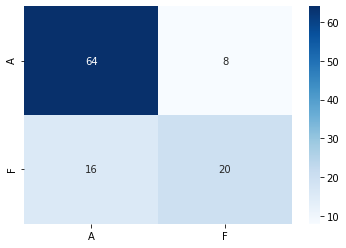

In [147]:
accuracy, cf_matrix, class_report = get_metrics(cat_boost_model, x_test, y_test)
print("accuracy_score: ", accuracy)
print("classification_report: \n", class_report)
sns.heatmap(cf_matrix, annot = True, xticklabels = grades, yticklabels = grades, cmap = 'Blues')

## SVM

In [136]:
from sklearn import svm

clf = svm.SVC()
clf.fit(x_train, y_train)
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

accuracy_score:  0.6759259259259259
classification_report: 
               precision    recall  f1-score   support

           A       0.68      0.99      0.80        72
           F       0.67      0.06      0.10        36

    accuracy                           0.68       108
   macro avg       0.67      0.52      0.45       108
weighted avg       0.67      0.68      0.57       108



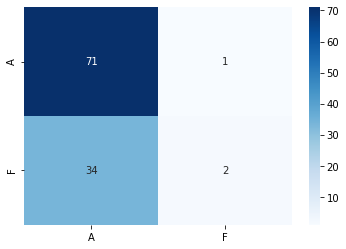

In [137]:
y_pred = clf.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred, labels = grades)
accuracy = accuracy_score(y_test, y_pred )
class_report = classification_report(y_test, y_pred)

print("accuracy_score: ", accuracy)
print("classification_report: \n", class_report)

sns.heatmap(cf_matrix, annot = True, xticklabels = grades, yticklabels = grades, cmap = 'Blues')

## Naive Bayes

In [138]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)
gnb.get_params()

{'priors': None, 'var_smoothing': 1e-09}

accuracy_score:  0.42592592592592593
classification_report: 
               precision    recall  f1-score   support

           A       0.71      0.24      0.35        72
           F       0.35      0.81      0.48        36

    accuracy                           0.43       108
   macro avg       0.53      0.52      0.42       108
weighted avg       0.59      0.43      0.40       108



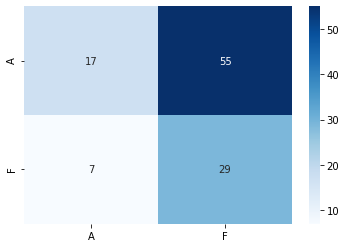

In [139]:
y_pred = gnb.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred, labels = grades)
accuracy = accuracy_score(y_test, y_pred )
class_report = classification_report(y_test, y_pred)

print("accuracy_score: ", accuracy)
print("classification_report: \n", class_report)

sns.heatmap(cf_matrix, annot = True, xticklabels = grades, yticklabels = grades, cmap = 'Blues')

## MLP

In [140]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=seed)
mlp.fit(x_train, y_train)
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 0,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [141]:
y_pred = mlp.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred, labels = grades)
accuracy = accuracy_score(y_test, y_pred )
class_report = classification_report(y_test, y_pred)

print("accuracy_score: ", accuracy)
print("classification_report: \n", class_report)

sns.heatmap(cf_matrix, annot = True, xticklabels = grades, yticklabels = grades, cmap = 'Blues')

accuracy_score:  0.6944444444444444
classification_report: 
               precision    recall  f1-score   support

           A       0.73      0.85      0.79        72
           F       0.56      0.39      0.46        36

    accuracy                           0.69       108
   macro avg       0.65      0.62      0.62       108
weighted avg       0.68      0.69      0.68       108

